In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import numpy as np
import scipy as sp
from scipy import stats as sps

import math
from collections import namedtuple
from functools import partial

In [2]:
data = pd.read_csv("chips.txt", header = None)

X = data.values[:,:2]
Y = data.values[:,2]

np.random.seed(0)
block_n = 10
permutation = np.random.permutation(len(X))

x_parts = np.array_split(X[permutation], block_n)
y_parts = np.array_split(Y[permutation], block_n)

In [3]:
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])

Params = namedtuple("Params", "k norm trans kernel")

In [4]:
step = 0.01
x_min, y_min = np.amin(X, axis = 0) - step
x_max, y_max = np.amax(X, axis = 0) + step

In [5]:
class knnClassifier():

    def __init__(self, params):
        self.params = params
        
    def fit(self, x, y):
        self.x = self.params.trans(x)
        self.y = y
        
    def predict(self, points):
        points = self.params.trans(points)
        ans = []
        for point in points:
            distances = self.params.norm(self.x - point, axis = -1)
            dist_arg_sorted = np.argsort(distances)
            norm_distance = distances[dist_arg_sorted[self.params.k + 1]]

            ys = np.unique(self.y)
            scores = [np.sum(self.params.kernel(distances / norm_distance) * (self.y == y))
                      for y in ys]
            ans.append(ys[np.argmax(scores)])
        return np.array(ans)

In [6]:
def precision(contingency_table):
    return contingency_table[1][1] / (contingency_table[1][1] + contingency_table[0][1])

def recall(contingency_table):
    return contingency_table[1][1] / (contingency_table[1][1] + contingency_table[0][0])

def fallout(contingency_table):
    return contingency_table[0][1] / (contingency_table[0][1] + contingency_table[1][0])

def f1_measure(contingency_table):
    p = precision(contingency_table)
    r = recall(contingency_table)
    return 2 * p * r / (p + r)

def f1_measure_reversed(contingency_table):
    ct = np.array(contingency_table)
    for i in [0, 1]:
        ct[i][0], ct[i][1] = ct[i][1], ct[i][0]
    return f1_measure(ct)

def cross_validate_vec(x_parts, y_parts, classifier, cl=1):
    cts = []
    for i in range(len(x_parts)):
        x_train = np.concatenate(np.delete(x_parts, i, 0))
        y_train = np.concatenate(np.delete(y_parts, i, 0))
        x_test = x_parts[i]
        y_test = y_parts[i]
        
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)

        true_positive  = np.sum(np.logical_and(y_pred == cl, y_test == cl))
        false_positive = np.sum(np.logical_and(y_pred == cl, y_test != cl))
        true_negative  = np.sum(np.logical_and(y_pred != cl, y_test != cl))
        false_negative = np.sum(np.logical_and(y_pred != cl, y_test == cl))

        contingency_table = [[0, 0], [0, 0]]
        contingency_table[1][1] = true_positive  / y_test.shape[0]
        contingency_table[0][1] = false_positive / y_test.shape[0]
        contingency_table[1][0] = true_negative  / y_test.shape[0]
        contingency_table[0][0] = false_negative / y_test.shape[0]
        cts.append(contingency_table)
    
    return np.array(cts)

def cross_validate(x_parts, y_parts, classifier, cl=1):
    return np.average(cross_validate_vec(x_parts, y_parts, classifier, cl), axis = 0)

In [7]:
def wilcoxon(x, y):
    d = x - y
    d = np.compress(np.not_equal(d, 0), d, axis=-1)
    count = len(d)
    
    r = sps.rankdata(np.abs(d))
    r_plus  = np.sum((d > 0) * r, axis = 0)
    r_minus = np.sum((d < 0) * r, axis = 0)
    
    T = min(r_plus, r_minus)
    return T
    

In [8]:
def identity(x):
    return x

def polar(x):
    return np.column_stack([
        np.sqrt(x[:,0] ** 2 + x[:,1] ** 2),
        np.arctan2(x[:,1], x[:,0])
    ])

def withPolar(x):
    return np.concatenate([x, polar(x)], axis = 1)

def withRadius(x):
    x = x - np.average(x, axis = 0)
    return np.column_stack([
        x[:,0],
        x[:,1],
        np.sqrt(x[:,0] ** 2 + x[:,1] ** 2)
    ])

def withSqr(x):
    x = x - np.average(x, axis = 0)
    return np.column_stack([
        x[:,0],
        x[:,1],
        x[:,0] ** 2,
        x[:,1] ** 2,
        x[:,0] * x[:,1]
    ])

def with3(x):
    x = x - np.average(x, axis = 0)
    return np.column_stack([
        x[:,0],
        x[:,1],
        x[:,0] ** 3,
        x[:,0] ** 2 * x[:,1],
        x[:,0] * x[:,1] ** 2,
        x[:,1] ** 3
    ])


def kernelConst(x):
    return (np.abs(x) < 1.0) * 0.5

def kernelTriangle(x):
    xabs = np.abs(x)
    return (xabs < 1.0) * (1.0 - xabs)

def kernelEpanechnikov(x):
    return 0.75 * (1.0 - x ** 2.0) * (np.abs(x) < 1.0)


params_set = [
    Params(k, partial(np.linalg.norm, ord = norm_ord), trans_f, kernel_f)
    for k in np.arange(2, round(math.sqrt(len(X)) + 1))
    for norm_ord in [
        1,
        1.5,
        2
    ]
    for trans_f in [
        identity,
        withSqr,
        withRadius,
        with3
    ]
    # Parzen-Rosenblatt window with variable window width
    for kernel_f in [
        kernelConst,
        kernelTriangle,
        kernelEpanechnikov
    ]
]

In [9]:
f1_measure_vec = np.vectorize(f1_measure, signature="(2,2)->()")
f1_0 = f1_measure_vec(cross_validate_vec(x_parts, y_parts, knnClassifier(params_set[0])))
f1_1 = f1_measure_vec(cross_validate_vec(x_parts, y_parts, knnClassifier(params_set[1])))

print(f1_0)
print(f1_1)

print(wilcoxon(f1_0, f1_1))

[ 0.5         0.66666667  0.83333333  0.72727273  0.93333333  0.9
  0.92307692  0.57142857  0.44444444  0.6       ]
[ 0.8         0.66666667  0.90909091  0.83333333  0.71428571  0.84210526
  0.83333333  0.5         0.4         0.54545455]
21.0


In [10]:
params_accuracies = [f1_measure(cross_validate(x_parts, y_parts, knnClassifier(p)))
                     for p in params_set]

In [11]:
best_params = params_set[np.argmax(params_accuracies)]
ct = cross_validate(x_parts, y_parts, knnClassifier(best_params))
print(f1_measure(ct))
print(f1_measure_reversed(ct))
print(best_params)

0.805116629044
0.802440884821
Params(k=11, norm=functools.partial(<function norm at 0x7fa8fb8cd7b8>, ord=1), trans=<function identity at 0x7fa8f39a98c8>, kernel=<function kernelTriangle at 0x7fa8ed66ed90>)


In [12]:
class Demonstrator():
    
    def __init__(self, x_min, y_min, x_max, y_max, step, classifier):
        self.x_min = x_min
        self.y_min = y_min
        self.x_max = x_max
        self.y_max = y_max
        self.step = step
        self.classifier = classifier
        
    def prepare(self, x, y):
        self.x = x
        self.y = y
        
        xx, yy = np.meshgrid(np.arange(self.x_min, self.x_max, self.step),
                             np.arange(self.y_min, self.y_max, self.step))
        self.xx = xx
        self.yy = yy

        self.classifier.fit(x, y)
        points = np.column_stack([self.xx.reshape((-1)), self.yy.reshape((-1))])
        self.zz = np.array([self.classifier.predict([p]) for p in points]).reshape(xx.shape)

    def plot(self):
        plt.figure(figsize=(15, 15))
        plt.xlim(self.x_min, self.x_max)
        plt.ylim(self.y_min, self.y_max)

        x0, y0 = self.x[self.y == 0].T
        x1, y1 = self.x[self.y == 1].T

        plt.pcolormesh(self.xx, self.yy, self.zz, cmap = cmap_light)
        plt.scatter(x0, y0, marker = 'D', color = 'red',  s = 50)
        plt.scatter(x1, y1, marker = 'o', color = 'blue', s = 50)
        plt.show()

In [13]:
d = Demonstrator(x_min, y_min, x_max, y_max, step, knnClassifier(best_params))
d.prepare(X, Y)

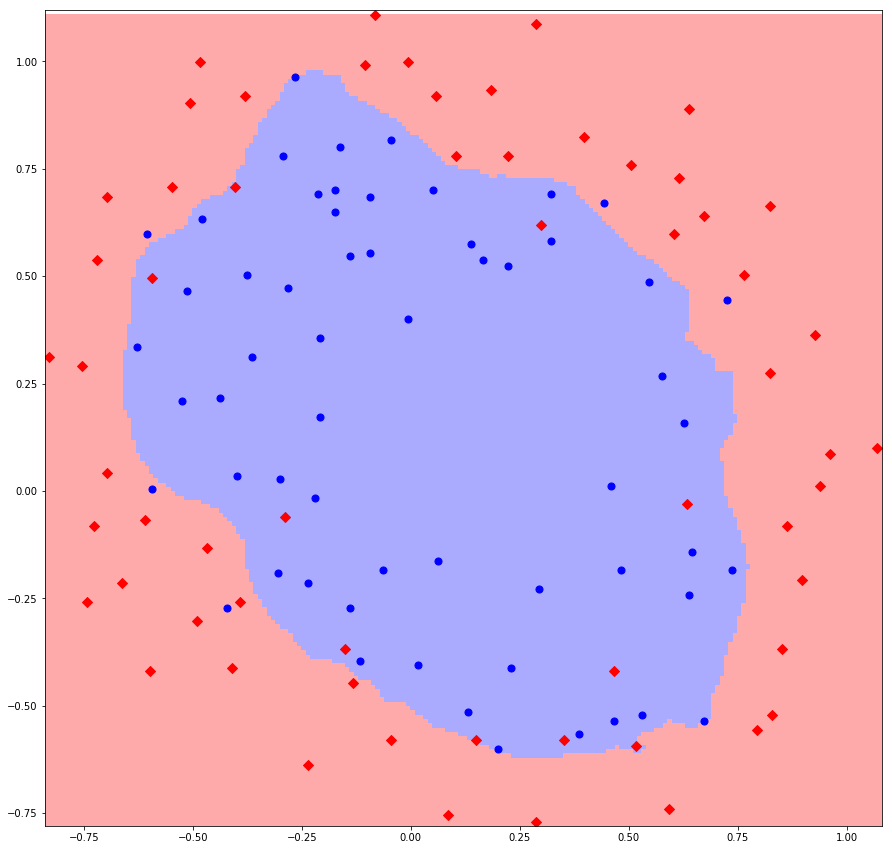

In [14]:
d.plot()